In [93]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from read_lammps_dump import read_dump

In [94]:
df = read_dump(os.path.join("velocity-distribution", "dump.lammpstrj"))

In [95]:
df.head()

,id,type,x,y,z,vx,vy,vz
0,1,1,0.00000,0.0,0.0,1.012100,0.213251,0.089516
1,5,1,7.36806,0.0,0.0,-0.153176,1.079850,0.001031
2,9,1,14.73610,0.0,0.0,-0.720942,-2.585440,-0.917600
3,13,1,22.10420,0.0,0.0,-2.083530,1.666840,0.965032
4,17,1,29.47230,0.0,0.0,-2.568510,-2.529350,-2.628410


In [96]:
df["v"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2 + df["vz"] ** 2)

In [97]:
df.head()

,id,type,x,y,z,vx,vy,vz,v
0,1,1,0.00000,0.0,0.0,1.012100,0.213251,0.089516,1.038189
1,5,1,7.36806,0.0,0.0,-0.153176,1.079850,0.001031,1.090660
2,9,1,14.73610,0.0,0.0,-0.720942,-2.585440,-0.917600,2.836591
3,13,1,22.10420,0.0,0.0,-2.083530,1.666840,0.965032,2.837383
4,17,1,29.47230,0.0,0.0,-2.568510,-2.529350,-2.628410,4.461322


In [98]:
df["timestep"] = 0

In [99]:
num_timesteps = 501
num_atoms = 4000

for i in range(num_timesteps):
    df.loc[i * num_atoms:(i + 1) * num_atoms, "timestep"] = i

In [100]:
df.tail()

,id,type,x,y,z,vx,vy,vz,v,timestep
2003995,2146,1,20.6496,70.5749,72.5053,-1.441580,0.016375,1.677140,2.211610,500
2003996,2998,1,22.3193,72.7661,73.1262,-0.774966,-1.859060,-0.652021,2.117028,500
2003997,71,1,38.6321,72.0330,73.1013,0.126816,-0.569508,-0.575847,0.819769,500
2003998,1433,1,67.9368,73.1790,72.2959,-2.354610,1.715020,-0.330291,2.931650,500
2003999,980,1,70.9225,73.3010,72.1290,0.398853,-3.297080,2.541540,4.182015,500


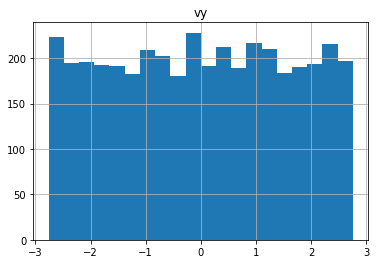

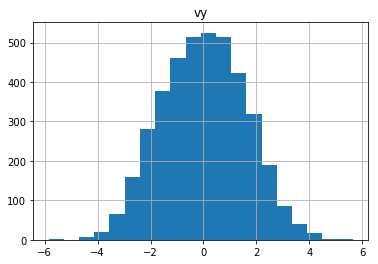

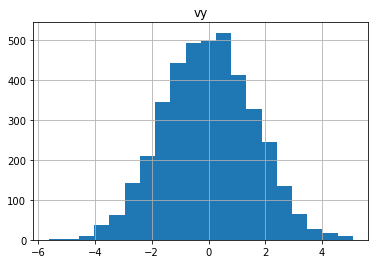

In [105]:
hist = df.head(4000).hist(bins=20, column=["vy"])
df[250 * 4000:251 * 4000].hist(bins=20, column=["vy"])
df.tail(4000).hist(bins=20, column=["vy"])
plt.show()